# Testing the Linear Model trained in TensorFlow 

In [1]:
from __future__ import print_function
from link_bot_notebooks import toy_problem_optimization_common as tpo
from math import acos
import numpy as np
import matplotlib.pyplot as plt
from link_bot_notebooks.linear_tf_model import LinearTFModel
from link_bot_agent import gurobi_act

plt.style.use('slides')

In [2]:
args = {'checkpoint': "log_data/random_50_all_training_low_B/December_13_16:00:58__19abfb2b9e/nn.ckpt-320000", 'log': False, 'batch_size': 1024}
dataset = "../../../link_bot_teleop/data/random_50_steps.txt"
n_steps = 50
dt = 0.1
x = tpo.load_train(dataset, N=6, L=2, n_steps=n_steps, extract_func=tpo.link_pos_vel_extractor2(6))
model = LinearTFModel(args, N=6, M=2, L=2, n_steps=1, dt=dt)
model.load()
print(model)

INFO:tensorflow:Restoring parameters from log_data/random_50_all_training_low_B/December_13_16:00:58__19abfb2b9e/nn.ckpt-320000
Restored ckpt log_data/random_50_all_training_low_B/December_13_16:00:58__19abfb2b9e/nn.ckpt-320000 at step 320000
A:
[[ 0.3551205   0.6942904   0.02156612  0.04249443  0.09005641  0.1564453 ]
 [ 0.7079558  -0.43318188  0.11999133  0.04310485  0.11987302 -0.0473155 ]]
B:
[[-0.00056419  0.00099494]
 [-0.00055121 -0.00019522]]
C:
[[ 0.31328103  0.60888875]
 [ 0.5606452  -0.3318096 ]]
D:
[[ 0.9667658  -0.1335865 ]
 [ 0.12174782  0.99731106]]



In [8]:
goal = np.array([[0], [0], [0], [1], [0], [2]])
og = model.reduce(goal)
max_v = 1
action_selector = gurobi_act.GurobiAct(model, og, max_v)

## Why is it getting stuck near the goal?

In [31]:
o = np.array([[0.35191],  [-0.050172]])
print('starting o', o.T)
u = action_selector.act(o)
print('optimal u', u[0].T)
o_ = model.predict(o, u)
print('predicted o after optimal action', o_.T)
print("og", og.T)
print('d to og for u', (o_-og).T)
c_ = model.predict_cost(o, u, goal)
print('cost of optimal u', c_)
my_u = np.array([[[0],  [-1]]])
my_o_ = model.predict(o, my_u)
c_ = model.predict_cost(o, my_u, goal)
print('d to og for my u', (my_o_-og).T)
print('cost of my u', c_)

starting o [[ 0.35191  -0.050172]]
optimal u [[0.0119988  0.05849755]]
predicted o after optimal action [[ 0.35559928 -0.05162448]]
og [[ 0.35538504 -0.05152614]]
d to og for u [[ 2.142489e-04 -9.833649e-05]]
cost of optimal u [[5.427054e-08]]
d to og for my u [[-0.06461239  0.03435092]]
cost of my u [[0.00523911]]


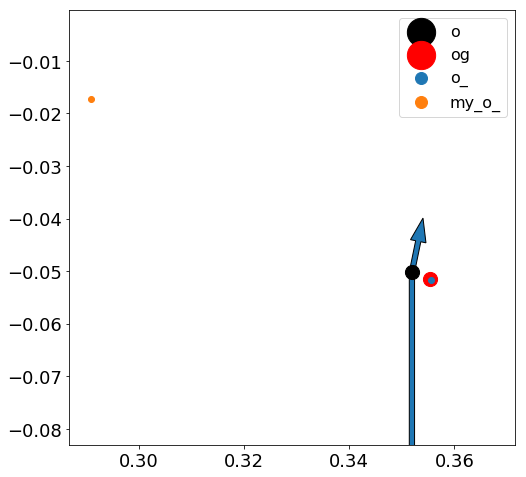

In [42]:
plt.figure(figsize=(8,8))
plt.arrow(o[0,0], o[1,0], u[0,0,0]*0.1, u[0,1,0]*0.1, zorder=1)
plt.arrow(o[0,0], o[1,0], my_u[0,0,0]*0.1, my_u[0,1,0]*0.1, zorder=1)
plt.scatter(o[0,0], o[1,0], label='o', zorder=2, c='k', s=200)
plt.scatter(og[0,0],og[1,0], label='og', c='r', zorder=2, s=200)
plt.scatter(o_[0,0], o_[1,0], label='o_', zorder=2)
plt.scatter(my_o_[0,0], my_o_[1,0], label='my_o_', zorder=2)
plt.axis("equal")
plt.legend();

# Visualize Model & Actions

In [5]:
data = tpo.load_data(dataset, g=goal, extract_func=tpo.two_link_pos_vel_extractor)

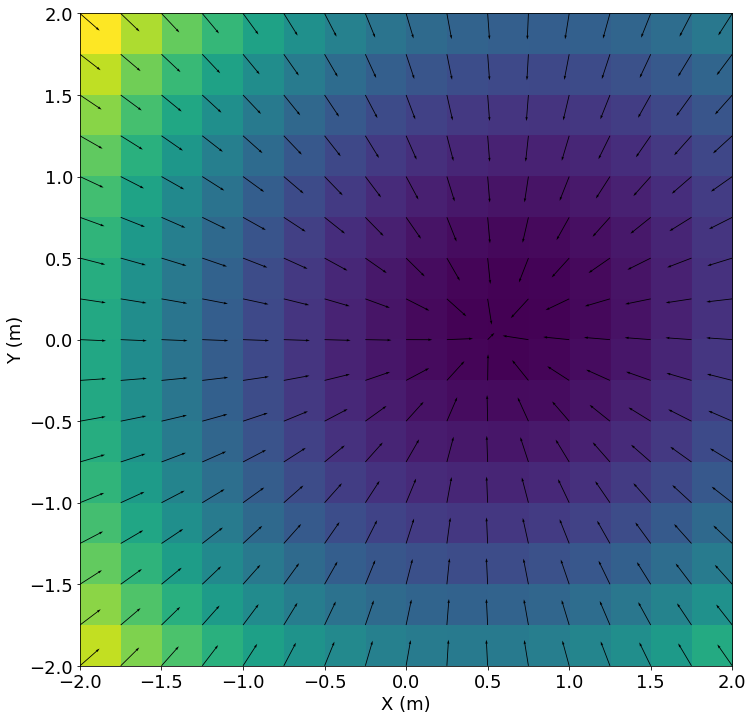

In [6]:
plt.figure(figsize=(12,12))
m = 2 
c = 0
res = 0.25
tpo.plot_costmap_2(plt, model, data, goal, resolution=res, minimum=c-m, maximum=c+m)
ax = plt.gca()
tpo.policy_quiver(model, action_selector, goal, ax, c, c, res, m, scale=25)
plt.xlabel("X (m)")
plt.ylabel("Y (m)");

[[ 1.04941091  0.2747739 ]
 [ 1.40453142  0.98272967]
 [ 1.3885808  -0.86636376]
 [ 0.33916989 -1.14113766]
 [-0.35512051 -0.70795578]
 [-1.04941091 -0.2747739 ]
 [-0.6942904   0.43318188]
 [-0.33916989  1.14113766]]


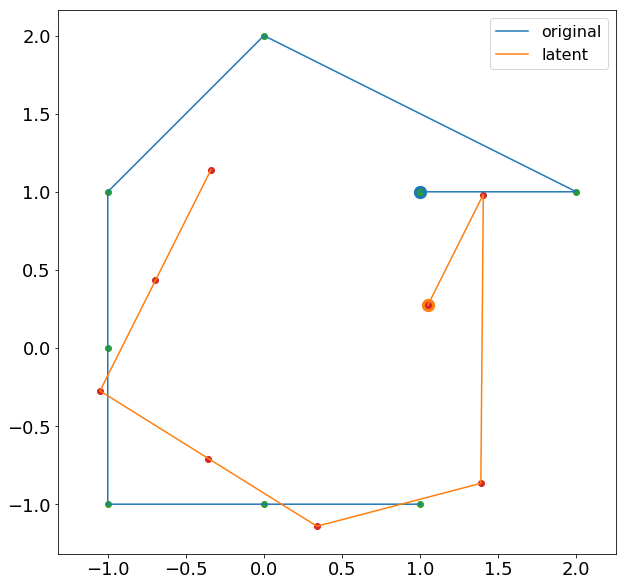

In [7]:
%matplotlib inline
points = np.array([[1,1], [2,1], [0,2], [-1,1], [-1,0], [-1,-1], [0,-1], [1,-1]])
R = model.get_A()[:,:2]
new_points = []
for p in points:
    new_p = np.dot(R, p)
    new_points.append(new_p)
new_points = np.array(new_points)
print(new_points)
    
plt.figure(figsize=(10,10))
plt.scatter([points[0,0]], [points[0,1]], s=150)
plt.scatter([new_points[0,0]], [new_points[0,1]], s=150)
plt.scatter([p[0] for p in points], [p[1] for p in points])
plt.scatter([p[0] for p in new_points], [p[1] for p in new_points])
plt.plot([p[0] for p in points], [p[1] for p in points], label='original')
plt.plot([p[0] for p in new_points], [p[1] for p in new_points], label='latent')
plt.legend()
plt.axis("equal");